In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip uninstall -y ultralytics
!pip install -U ultralytics==8.3.221

import ultralytics, torch, sys
print("Ultralytics:", ultralytics.__version__)
print("Torch:", torch.__version__)
print("Python:", sys.version)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics: 8.3.221
Torch: 2.8.0+cu126
Python: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]


In [3]:
# Colab/Environment setup
!pip -q install pyyaml==6.0.2 pandas==2.2.2 matplotlib==3.9.0 opencv-python==4.10.0.84

import os, json, random, shutil, ast, textwrap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from ultralytics import YOLO


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 767.5/767.5 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 34.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 9.4 MB/s eta 0:00:00


In [4]:
# Add your own Drive path that contains mosaic_data
BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/Emotic/mosaic_data"  # <-- change this if needed

CSV_PATH   = f"{BASE_DIR}/mosaic_photos.csv"
IMAGES_DIR = f"{BASE_DIR}/images"
JSONL_PATH = f"{BASE_DIR}/annotations.jsonl"

# Hard checks
assert os.path.isdir(BASE_DIR),  f"Folder not found: {BASE_DIR}"
assert os.path.isfile(CSV_PATH), f"CSV not found: {CSV_PATH}"
assert os.path.isdir(IMAGES_DIR),f"Images folder not found: {IMAGES_DIR}"
assert os.path.isfile(JSONL_PATH), f"JSONL not found: {JSONL_PATH}"

# Quick peek: show counts and a few filenames
num_images = len([p for p in Path(IMAGES_DIR).glob("*") if p.suffix.lower() in {'.png','.jpg','.jpeg'}])
print(f" Found dataset at {BASE_DIR}")
print(f"• images/: {num_images} files")
print(f"• mosaic_photos.csv size: {os.path.getsize(CSV_PATH)/1024:.1f} KB")
print(f"• annotations.jsonl size: {os.path.getsize(JSONL_PATH)/1024:.1f} KB")



 Found dataset at /content/drive/MyDrive/Colab Notebooks/Emotic/mosaic_data
• images/: 200 files
• mosaic_photos.csv size: 197.2 KB
• annotations.jsonl size: 209.8 KB


In [5]:
# Quick EDA on the mosaic dataset

import ast
import pandas as pd

CSV_PATH = f"{BASE_DIR}/mosaic_photos.csv"

# --- helper to safely parse list-like strings ---
def parse_literal(s):
    if pd.isna(s):
        return []
    try:
        return ast.literal_eval(s)
    except Exception as e:
        print("parse error:", s[:80], e)
        return []

# --- read and convert ---
df = pd.read_csv(CSV_PATH)
df['categories'] = df['categories'].apply(parse_literal)
df['bbox']       = df['bbox'].apply(parse_literal)

print(f"Loaded {len(df)} rows")
display(df.head(3))


Loaded 200 rows


,image_file,original_width,original_height,people_count,categories,bbox,source_paths
0,images/mosaic_00001.png,1024,683,9,"[Neutral, Happy, Surprised, Sad, Angry, Fear, ...","[[27.44140625, 70.27818448023426, 4.6875, 7.02...","[""../Mosaic_data_folders/data/raw_data/FER-201..."
1,images/mosaic_00002.png,1024,683,2,"[Neutral, Happy]","[[49.70703125, 55.19765739385066, 9.08203125, ...","[""../Mosaic_data_folders/data/raw_data/FER-201..."
2,images/mosaic_00003.png,1024,683,8,"[Neutral, Happy, Surprised, Sad, Angry, Fear, ...","[[48.828125, 52.12298682284041, 4.6875, 7.0278...","[""../Mosaic_data_folders/data/raw_data/FER-201..."


In [6]:
print("\n--- Basic Info ---")
print(df.info())

# unique images and columns
print(f"\nUnique image files: {df['image_file'].nunique()}")

# check that list lengths match declared people_count
length_ok = (df['people_count'] == df['categories'].apply(len)) & \
            (df['people_count'] == df['bbox'].apply(len))
print(f"Rows with consistent counts: {length_ok.sum()} / {len(df)}")
if not length_ok.all():
    display(df[~length_ok].head())



--- Basic Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   image_file       200 non-null    object
 1   original_width   200 non-null    int64 
 2   original_height  200 non-null    int64 
 3   people_count     200 non-null    int64 
 4   categories       200 non-null    object
 5   bbox             200 non-null    object
 6   source_paths     200 non-null    object
dtypes: int64(3), object(4)
memory usage: 11.1+ KB
None

Unique image files: 200
Rows with consistent counts: 200 / 200


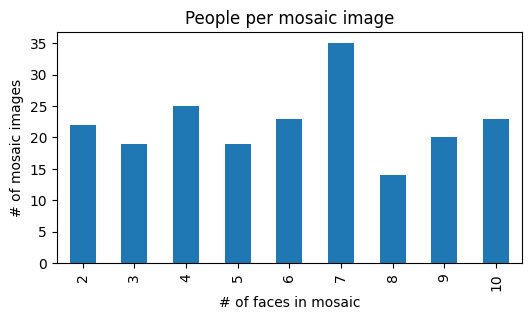

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,3))
df['people_count'].value_counts().sort_index().plot(kind='bar')
plt.title("People per mosaic image")
plt.xlabel("# of faces in mosaic")
plt.ylabel("# of mosaic images")
plt.show()


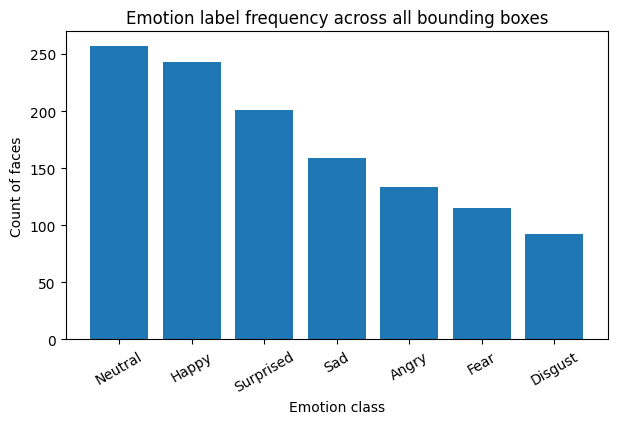

Emotion counts: {'Neutral': 257, 'Happy': 243, 'Surprised': 201, 'Sad': 159, 'Angry': 134, 'Fear': 115, 'Disgust': 92}
Neutral   :  257  ( 21.4%)
Happy     :  243  ( 20.2%)
Surprised :  201  ( 16.7%)
Sad       :  159  ( 13.2%)
Angry     :  134  ( 11.2%)
Fear      :  115  (  9.6%)
Disgust   :   92  (  7.7%)

Total labeled faces (bboxes): 1201


In [8]:
# Emotion balance and label exploration

from collections import Counter
import matplotlib.pyplot as plt

# Flatten all emotion labels across all mosaics
emotion_counter = Counter()
for cats in df['categories']:
    emotion_counter.update(cats)

# canonical emotion order (for consistent plotting)
EMOTIONS = ["Neutral","Happy","Surprised","Sad","Angry","Fear","Disgust"]

# reorder & prepare for plotting
counts = [emotion_counter.get(e,0) for e in EMOTIONS]

plt.figure(figsize=(7,4))
bars = plt.bar(EMOTIONS, counts)
plt.title("Emotion label frequency across all bounding boxes")
plt.xlabel("Emotion class")
plt.ylabel("Count of faces")
plt.xticks(rotation=30)
plt.show()

print("Emotion counts:", dict(emotion_counter))
total_faces = sum(counts)
for e, c in zip(EMOTIONS, counts):
    print(f"{e:10s}: {c:4d}  ({100*c/total_faces:5.1f}%)")

print(f"\nTotal labeled faces (bboxes): {total_faces}")


In [9]:
import numpy as np

counts_arr = np.array(counts)
ratio_maxmin = counts_arr.max() / counts_arr.min() if counts_arr.min() > 0 else np.inf
print(f"Class balance ratio (max/min): {ratio_maxmin:.2f}")

if ratio_maxmin > 3:
    print(" Imbalance detected — consider class weighting, focal loss, or sampling later.")
else:
    print(" Classes are reasonably balanced.")

Class balance ratio (max/min): 2.79
 Classes are reasonably balanced.


What this tells us:

Total faces (bboxes): 1,201 — solid sample size for 200 mosaics (≈6 faces/image on average).

Top emotions: Neutral (21%) and Happy (20%) — this is common, they tend to dominate FER-type datasets.

Least represented: Disgust (~8%) — still enough for learning (not vanishingly small).

Class balance ratio 2.79: good — within the “manageable imbalance” zone.

In [1]:
#import random, cv2
#import matplotlib.pyplot as plt

#SAMPLES = 4  # number of random mosaic images to check
#sample_rows = df.sample(SAMPLES, random_state=42)
'''
def draw_boxes(img, boxes_percent, cats, imw, imh, assume_top_left=True):
    """
    Draw boxes onto the image, interpreting (x, y) as either top-left or center.
    All bbox values are in percentages of image width/height.
    """
    img = img.copy()
    for (x,y,w,h), label in zip(boxes_percent, cats):
        if assume_top_left:
            # interpret x,y as top-left corner
            x1 = int(x/100.0 * imw)
            y1 = int(y/100.0 * imh)
            x2 = int((x+w)/100.0 * imw)
            y2 = int((y+h)/100.0 * imh)
        else:
            # interpret x,y as center point
            cx = x/100.0 * imw
            cy = y/100.0 * imh
            ww = w/100.0 * imw
            hh = h/100.0 * imh
            x1 = int(cx - ww/2)
            y1 = int(cy - hh/2)
            x2 = int(cx + ww/2)
            y2 = int(cy + hh/2)

        cv2.rectangle(img, (x1,y1), (x2,y2), (255,255,255), 2)
        cv2.putText(img, label, (x1, max(0,y1-5)), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 2)
    return img

for _, row in sample_rows.iterrows():
    img_path = os.path.join(BASE_DIR, row['image_file'])
    img = cv2.imread(img_path)
    assert img is not None, f" Missing image: {img_path}"
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    boxes = row['bbox']
    cats  = row['categories']

    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(draw_boxes(img_rgb, boxes, cats, w, h, assume_top_left=True))
    ax1.set_title('Assume x,y = TOP-LEFT')
    ax1.axis('off')

    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(draw_boxes(img_rgb, boxes, cats, w, h, assume_top_left=False))
    ax2.set_title('Assume x,y = CENTER')
    ax2.axis('off')

    plt.suptitle(row['image_file'])
    plt.show()
'''

'\ndef draw_boxes(img, boxes_percent, cats, imw, imh, assume_top_left=True):\n    """\n    Draw boxes onto the image, interpreting (x, y) as either top-left or center.\n    All bbox values are in percentages of image width/height.\n    """\n    img = img.copy()\n    for (x,y,w,h), label in zip(boxes_percent, cats):\n        if assume_top_left:\n            # interpret x,y as top-left corner\n            x1 = int(x/100.0 * imw)\n            y1 = int(y/100.0 * imh)\n            x2 = int((x+w)/100.0 * imw)\n            y2 = int((y+h)/100.0 * imh)\n        else:\n            # interpret x,y as center point\n            cx = x/100.0 * imw\n            cy = y/100.0 * imh\n            ww = w/100.0 * imw\n            hh = h/100.0 * imh\n            x1 = int(cx - ww/2)\n            y1 = int(cy - hh/2)\n            x2 = int(cx + ww/2)\n            y2 = int(cy + hh/2)\n\n        cv2.rectangle(img, (x1,y1), (x2,y2), (255,255,255), 2)\n        cv2.putText(img, label, (x1, max(0,y1-5)), cv2.FONT_HER

Next step,

• Make a reproducible train/val/test split by image

• Convert your CSV bboxes (percent, top-left) → YOLO txt (normalized center format)

• Build a clean directory ready for YOLOv11 training + a data.yaml

• Verify split balance quickly

In [11]:
import random
from collections import Counter
from pathlib import Path

# Reproducible split
random.seed(1337)
all_images = df['image_file'].unique().tolist()
random.shuffle(all_images)

n = len(all_images)
n_train = int(0.8*n)
n_val   = int(0.1*n)

train_imgs = set(all_images[:n_train])
val_imgs   = set(all_images[n_train:n_train+n_val])
test_imgs  = set(all_images[n_train+n_val:])

def subset_df(img_set):
    return df[df['image_file'].isin(img_set)].copy()

df_train = subset_df(train_imgs)
df_val   = subset_df(val_imgs)
df_test  = subset_df(test_imgs)

EMOTIONS = ["Neutral","Happy","Surprised","Sad","Angry","Fear","Disgust"]

def report_split(name, d):
    cnt = Counter([c for cats in d['categories'] for c in cats])
    faces = sum(d['people_count'])
    print(f"\n{name.upper():5s} | images={d['image_file'].nunique():3d}  faces={faces:4d}")
    for e in EMOTIONS:
        print(f"  {e:10s}: {cnt.get(e,0):4d}")

for nm, d in [("train", df_train), ("val", df_val), ("test", df_test)]:
    report_split(nm, d)



TRAIN | images=160  faces= 971
  Neutral   :  207
  Happy     :  196
  Surprised :  161
  Sad       :  126
  Angry     :  108
  Fear      :   93
  Disgust   :   80

VAL   | images= 20  faces= 118
  Neutral   :   27
  Happy     :   25
  Surprised :   20
  Sad       :   15
  Angry     :   12
  Fear      :   12
  Disgust   :    7

TEST  | images= 20  faces= 112
  Neutral   :   23
  Happy     :   22
  Surprised :   20
  Sad       :   18
  Angry     :   14
  Fear      :   10
  Disgust   :    5


In [12]:
# Convert to YOLO txts and build directory structure

import os, shutil, textwrap

# Emotion to class id
EMO2ID = {e:i for i,e in enumerate(EMOTIONS)}
BBOX_XY_IS_TOPLEFT = True

# Output project
OUT_ROOT = "/content/emo_yolo"
for sub in ["images/train","images/val","images/test","labels/train","labels/val","labels/test"]:
    os.makedirs(f"{OUT_ROOT}/{sub}", exist_ok=True)

def convert_row_to_yolo(row):
    """
    row.bbox is [[x,y,w,h]] in PERCENT of image, x,y = top-left
    Convert to YOLO normalized center format.
    """
    yolo_lines = []
    for (x,y,w,h), lab in zip(row['bbox'], row['categories']):
        cls = EMO2ID[lab]
        if BBOX_XY_IS_TOPLEFT:
            cx = (x + w/2.0) / 100.0
            cy = (y + h/2.0) / 100.0
            ww = w / 100.0
            hh = h / 100.0
        else:
            # (kept for completeness; not used since we confirmed top-left)
            cx = x / 100.0
            cy = y / 100.0
            ww = w / 100.0
            hh = h / 100.0
        # clamp for safety
        cx = min(max(cx, 0.0), 1.0)
        cy = min(max(cy, 0.0), 1.0)
        ww = min(max(ww, 0.0), 1.0)
        hh = min(max(hh, 0.0), 1.0)
        yolo_lines.append(f"{cls} {cx:.6f} {cy:.6f} {ww:.6f} {hh:.6f}")
    return yolo_lines

def export_split(split_df, split_name):
    img_out = f"{OUT_ROOT}/images/{split_name}"
    lbl_out = f"{OUT_ROOT}/labels/{split_name}"
    for img_rel in split_df['image_file'].unique():
        src_img = os.path.join(BASE_DIR, img_rel)
        base = Path(img_rel).stem

        # copy image (keep original extension)
        ext = Path(img_rel).suffix
        dst_img = f"{img_out}/{base}{ext}"
        shutil.copy2(src_img, dst_img)

        # write label file
        row = split_df[split_df['image_file']==img_rel].iloc[0]
        lines = convert_row_to_yolo(row)
        with open(f"{lbl_out}/{base}.txt", "w") as f:
            f.write("\n".join(lines) + "\n")

export_split(df_train, "train")
export_split(df_val,   "val")
export_split(df_test,  "test")
print("Exported images + labels to:", OUT_ROOT)




Exported images + labels to: /content/emo_yolo


In [13]:
# Write data.yaml for Ultralytics

yaml_text = f"""
path: {OUT_ROOT}
train: images/train
val: images/val
test: images/test

names:
  0: Neutral
  1: Happy
  2: Surprised
  3: Sad
  4: Angry
  5: Fear
  6: Disgust
"""
with open(f"{OUT_ROOT}/data.yaml","w") as f:
    f.write(textwrap.dedent(yaml_text).strip()+"\n")

print(open(f"{OUT_ROOT}/data.yaml").read())


path: /content/emo_yolo
train: images/train
val: images/val
test: images/test

names:
  0: Neutral
  1: Happy
  2: Surprised
  3: Sad
  4: Angry
  5: Fear
  6: Disgust



# Fine-tune YOLOv11 on mosaic dataset

Start with yolov11n.pt (nano) for speed; move to s if you have more GPU.

We disable Ultralytics’ mosaic/mixup/copy_paste (your images are already mosaics).

Gentle color aug; no perspective/shear (faces are sensitive to warps)

In [14]:
from ultralytics import YOLO
from pathlib import Path

# Choose your backbone: 'yolov11n.pt' | 'yolov11s.pt' | 'yolov11m.pt' | 'yolov11l.pt' | 'yolov11x.pt'
MODEL_WEIGHTS = 'yolo11n.pt'   # try 'yolov11s.pt' if you have T4/A100 and VRAM to spare

model = YOLO(MODEL_WEIGHTS)     # downloads weights on first use
DATA_YAML = f"{OUT_ROOT}/data.yaml"


In [15]:
from ultralytics import YOLO
MODEL_WEIGHTS = 'yolo11n.pt'
model = YOLO(MODEL_WEIGHTS)

DATA_YAML  = f"{OUT_ROOT}/data.yaml"
RESULTS_DIR = "/content/emo_yolo/runs"

train_results = model.train(
    data=DATA_YAML,
    project=RESULTS_DIR,
    name="emo_y11n",
    exist_ok=True,

    epochs=100,
    patience=20,        # early stopping
    batch=16,
    imgsz=640,
    workers=2,
    amp=True,

    mosaic=0.0, mixup=0.0, copy_paste=0.0,
    fliplr=0.5, flipud=0.0,
    hsv_h=0.015, hsv_s=0.7, hsv_v=0.4,
    perspective=0.0, shear=0.0,

    box=7.5, cls=0.5,
    lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005,
)

print("Run directory:", train_results.save_dir)



Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/emo_yolo/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=0.0, multi_scale=False, name=emo_y11n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=

# The following result is only on the test set from mosaic dataset. We'll run a separate code for the finalized test set.

In [16]:
test_metrics = model.val(data=f"{OUT_ROOT}/data.yaml", split='test')
print(test_metrics.results_dict)


Ultralytics 8.3.221 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLO11n summary (fused): 100 layers, 2,583,517 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2299.8±1164.1 MB/s, size: 292.8 KB)
val: Scanning /content/emo_yolo/labels/test... 20 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 20/20 637.9it/s 0.0s
val: New cache created: /content/emo_yolo/labels/test.cache
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 1.4it/s 1.4s
                   all         20        112      0.352      0.435        0.4      0.362
               Neutral         20         23      0.281      0.478      0.302      0.267
                 Happy         20         22      0.419       0.82      0.553      0.514
             Surprised         18         20      0.676        0.7      0.807      0.728
                   Sad         18         18      0.285      0.389      0.324      0